# ***Tarea 3. Regresión y AB testing***
### Luis Eduardo Jiménez del Muro - 11/02/2025
---

## Paqueterías y funciones

In [144]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import warnings
warnings.filterwarnings('ignore')

In [139]:
## Crea una función de calibracion
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    r2 = r2_score(y_pred=predicciones, y_true=y)
    
    plt.figure(figsize=(8,6))
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', marker='o', color='cadetblue', ms=4, lw=1)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='red', ms=4, lw=1)
    plt.title(f'Calibración del modelo \n\n$R2={r2:.4f}$')
    plt.grid(alpha=0.5)
    plt.legend()
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    
## Crea un código base para el AB test
def AB_test(test, control):
    # Mu
    mu_test = test.mean()
    mu_control = control.mean()
    
    # SE
    se_test = test.sem()
    se_control = control.sem()
    
    # Differences
    mu_diff = mu_control - mu_test
    se_diff = np.sqrt((test.var() / len(test) + (control.var() / len(control))))
    
    # Z score and p value 
    z = mu_diff / se_diff
    p_value = stats.norm.cdf(z)
    
    # Resultados
    print(f'Variable test entre {(mu_test - 2*se_test):.4f} y {(mu_test + 2*se_test):.4f}')
    print(f'Variable control entre {(mu_control - 2*se_control):.4f} y {(mu_control + 2*se_control):.4f}')
    print(f'Z score: {z:.4f}')
    print(f'P value: {p_value:.4f}')

## Preparación de los datos

In [75]:
df = pd.read_csv('day.csv')
df = df.drop(columns=['casual', 'registered', 'instant', 'yr', 'mnth', 'dteday'])

categoricas = ['season', 'weekday', 'weathersit']
df = pd.get_dummies(df, columns=categoricas)
df.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,0,0.344167,0.363625,0.805833,0.160446,985,True,False,False,...,False,False,False,False,False,False,True,False,True,False
1,0,0,0.363478,0.353739,0.696087,0.248539,801,True,False,False,...,True,False,False,False,False,False,False,False,True,False
2,0,1,0.196364,0.189405,0.437273,0.248309,1349,True,False,False,...,False,True,False,False,False,False,False,True,False,False
3,0,1,0.200000,0.212122,0.590435,0.160296,1562,True,False,False,...,False,False,True,False,False,False,False,True,False,False
4,0,1,0.226957,0.229270,0.436957,0.186900,1600,True,False,False,...,False,False,False,True,False,False,False,True,False,False


## Visualización de datos con Análisis Bivariado

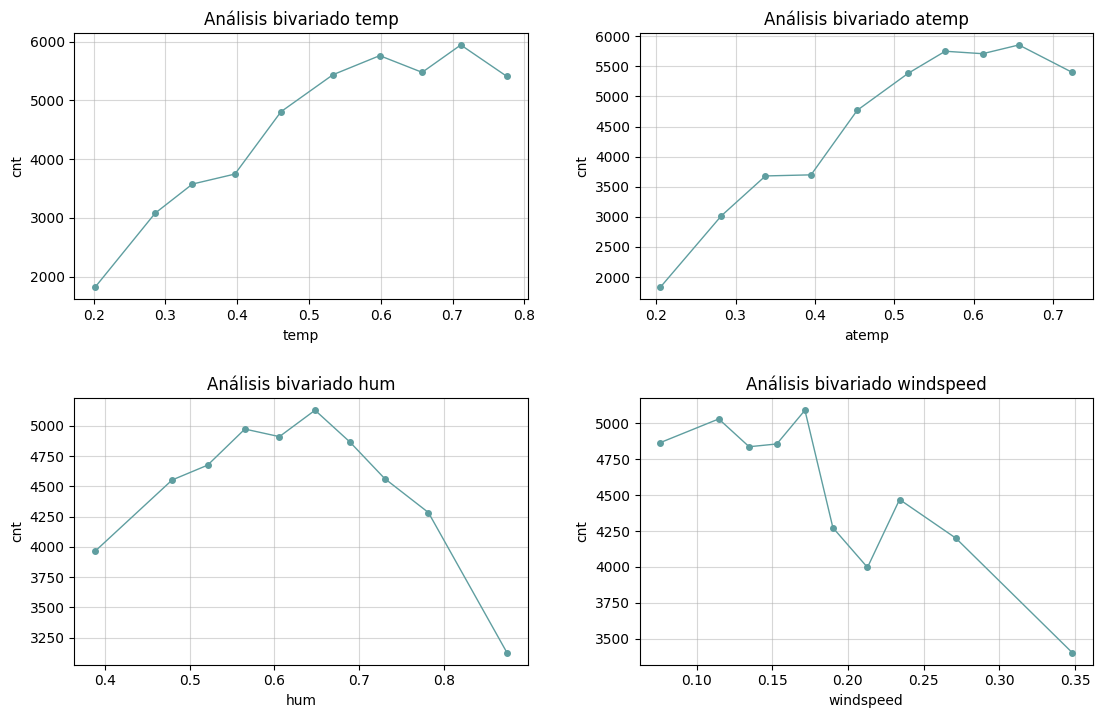

In [76]:
numericas = ['temp', 'atemp', 'hum', 'windspeed']

df_bivariado = df.copy()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(pad=5)

for i, ax in enumerate(axes.flat):
    df_bivariado[f'{numericas[i]}_bins'] = pd.qcut(df_bivariado[numericas[i]], q=10, labels=False) + 1
    grouped_data = df_bivariado.groupby(f'{numericas[i]}_bins').mean()
    
    ax.plot(grouped_data[numericas[i]], grouped_data['cnt'], marker='o', color='cadetblue', lw=1, markersize=4)
    ax.set_title(f'Análisis bivariado {numericas[i]}')
    ax.set_xlabel(numericas[i])
    ax.set_ylabel('cnt')
    ax.grid(alpha=0.5)

plt.show()

## Modelos de prueba

In [77]:
target = 'cnt'
X = df.copy().drop(columns=[target])
y = df[target]

### Regresión lineal múltiple

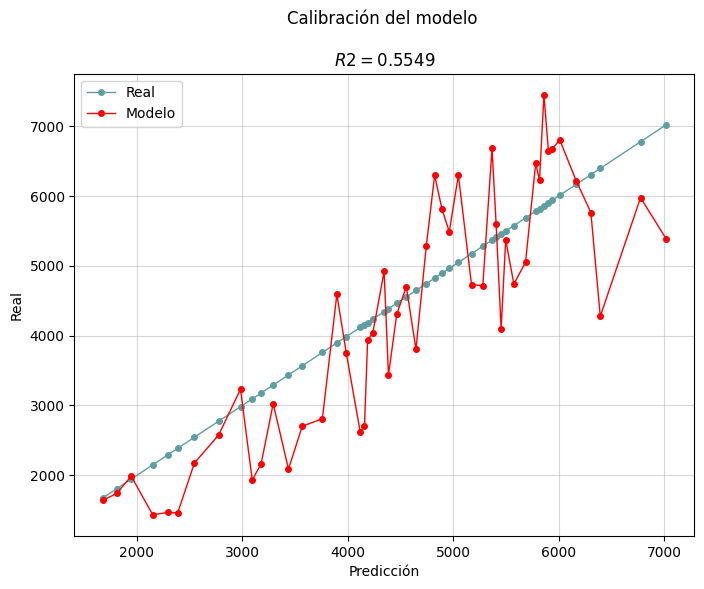

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = linear_model.LinearRegression().fit(X_train, y_train)
predicciones_lineal = model.predict(X_test)
calibracion(predicciones_lineal, y_test, 50)

### Modelo polinomial de grado 2

#### Aplicar StandardScaler

In [79]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

#### Modelo

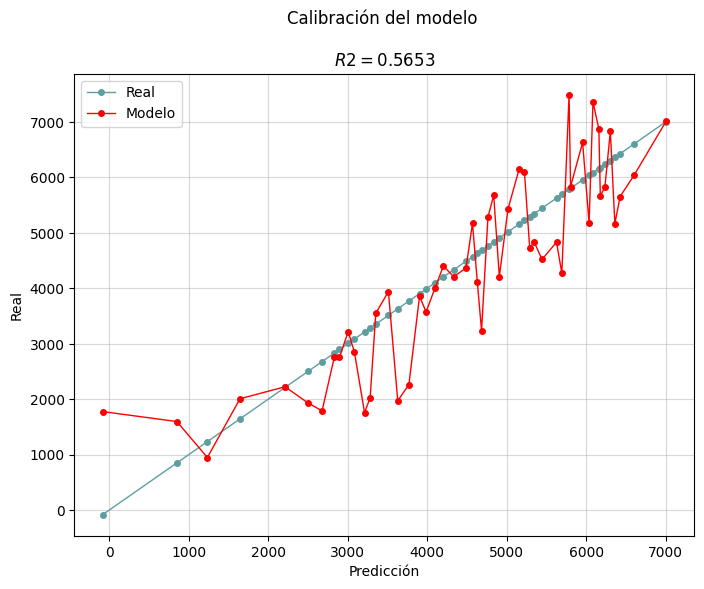

In [80]:
degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = linear_model.Lasso().fit(X_train, y_train)
predicciones_poly_2 = model.predict(X_test)

calibracion(predicciones_poly_2, y_test, 50)

### Modelo polinomial de grado 3

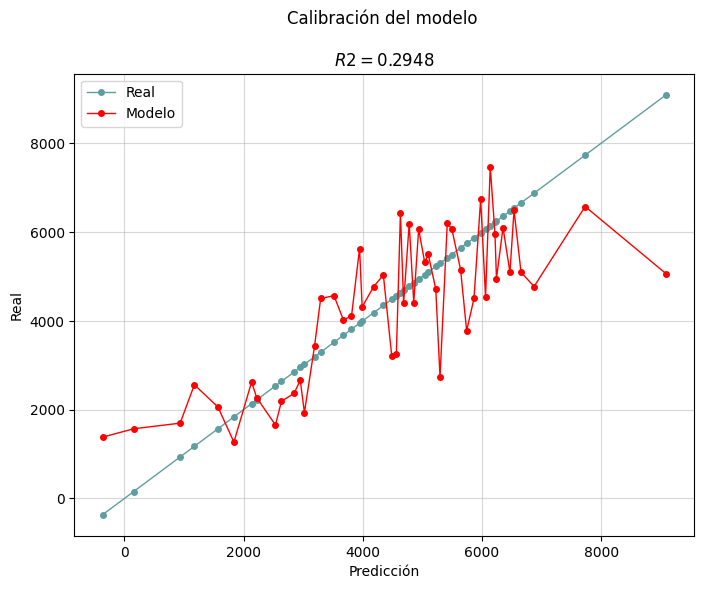

In [81]:
degree = 3

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = linear_model.Lasso().fit(X_train, y_train)
predicciones_poly_3 = model.predict(X_test)

calibracion(predicciones_poly_3, y_test, 50)

## Realizar Feature Engeneering

+ Relacionar `temp` con `atemp`.
+ Elevar al cuadrado todas las variables, dado que en el bivariado se observó que podrían ajustarse parábolas.

In [82]:
df_fe = df.copy()

df_fe['temp_atemp'] = df_fe['temp'] / df_fe['atemp']

df_fe['hum_2'] = df_fe['hum']**2
df_fe['temp_2'] = df_fe['temp']**2
df_fe['atemp_2'] = df_fe['atemp']**2
df_fe['windspeed_2'] = df_fe['windspeed']**2

## Modelos despues de Feature Engeneering

In [83]:
target = 'cnt'
X = df_fe.copy().drop(columns=[target])
y = df_fe[target]

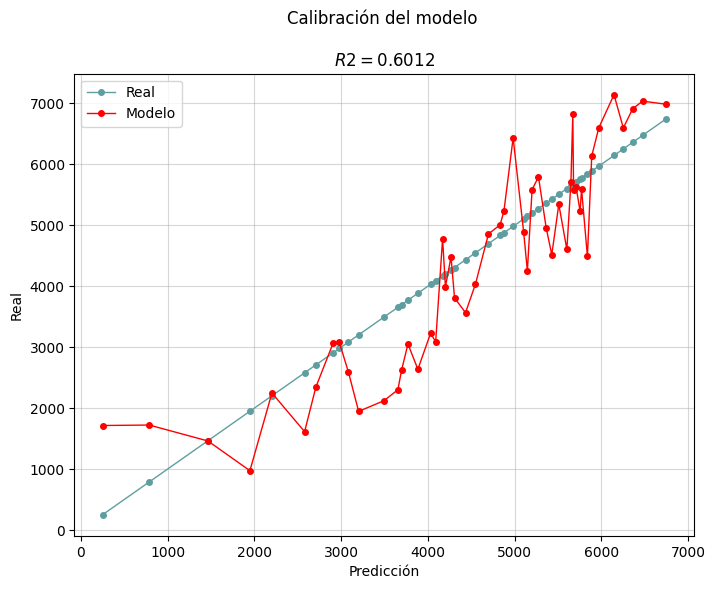

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = linear_model.LinearRegression().fit(X_train, y_train)
predicciones_lineal = model.predict(X_test)
calibracion(predicciones_lineal, y_test, 50)

### Modelo polinomial de grado 2

#### Aplicar StandardScaler

In [86]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

#### Modelo

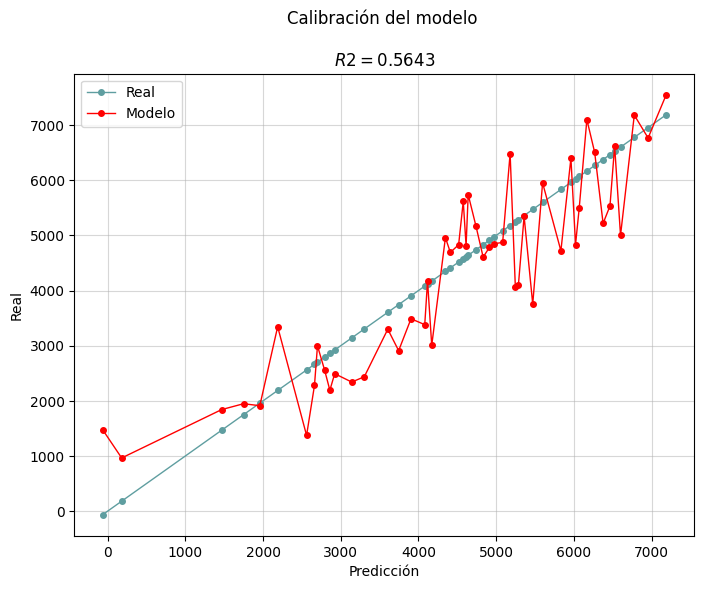

In [87]:
degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = linear_model.Lasso().fit(X_train, y_train)
predicciones_poly_2 = model.predict(X_test)

calibracion(predicciones_poly_2, y_test, 50)

### Modelo polinomial de grado 3

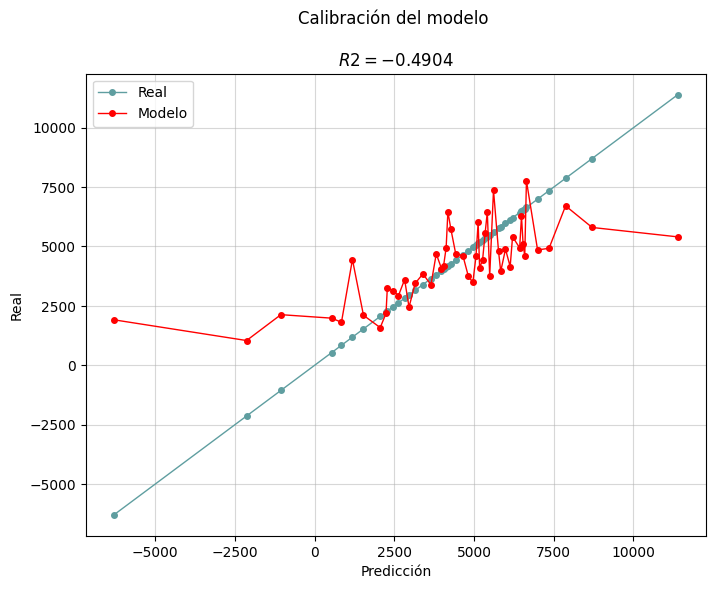

In [88]:
degree = 3

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = linear_model.Lasso().fit(X_train, y_train)
predicciones_poly_3 = model.predict(X_test)

calibracion(predicciones_poly_3, y_test, 50)

## Modelo Final 

El modelo a utilizar es la regresión lineal múltiple utilizando las columnas del Feature Engeneering.

**************** Resultados del modelo ****************

El R2 del modelo es: 0.6012
El MSE del modelo es: 1599114.3331

El intercepto del modelo es: 2352.2775

Coeficientes del modelo:


,Variable,Coeficiente
0,holiday,-510.292461
1,workingday,237.811443
2,temp,76734.685229
3,atemp,-54966.669707
4,hum,5561.707786
5,windspeed,-3906.429664
6,season_1,-451.581425
7,season_2,-67.275737
8,season_3,37.374907
9,season_4,481.482255




Calibración del modelo:


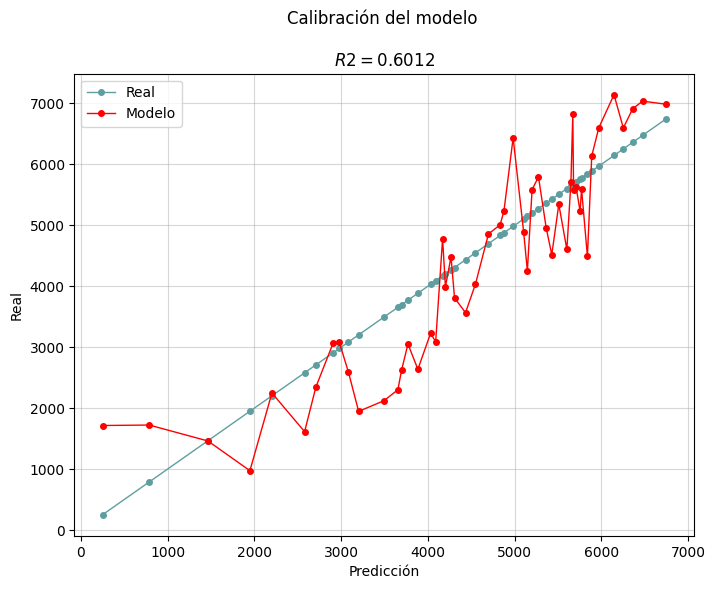

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = linear_model.LinearRegression().fit(X_train, y_train)
predicciones_lineal = model.predict(X_test)
coeficientes = pd.DataFrame({'Variable': X_train.columns, 'Coeficiente': model.coef_})


print('**************** Resultados del modelo ****************')
print(f'\nEl R2 del modelo es: {r2_score(y_pred=predicciones_lineal, y_true=y_test):.4f}')
print(f'El MSE del modelo es: {mean_squared_error(y_pred=predicciones_lineal, y_true=y_test):.4f}')
print(f'\nEl intercepto del modelo es: {model.intercept_:.4f}')
print("\nCoeficientes del modelo:")
display(coeficientes)
print('\n\nCalibración del modelo:')
calibracion(predicciones_lineal, y_test, 50)

# AB testing para holiday y workingday

In [140]:
df = pd.read_csv('day.csv')
df = df[['workingday', 'holiday', 'cnt']]
df.head()

,workingday,holiday,cnt
0,0,0,985
1,0,0,801
2,1,0,1349
3,1,0,1562
4,1,0,1600


## AB testing a mano

In [141]:
test = df[df['holiday'] == 1]['cnt']
control = df[df['workingday'] == 1]['cnt']

AB_test(test, control)

Variable test entre 2817.0225 y 4652.9775
Variable control entre 4416.8094 y 4752.8306
Z score: 1.8213
P value: 0.9657


## AB testing con la paquetería de statsmodel

In [146]:
result = smf.ols('cnt ~ holiday + workingday', data=df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4389.6857,133.413,32.903,0.000,4127.766,4651.605
holiday,-654.6857,442.480,-1.480,0.139,-1523.375,214.004
workingday,195.1343,158.980,1.227,0.220,-116.979,507.248
